In [22]:
import os
import time
import copy
import urllib.request
import zipfile

# PyTorch
import torch
from torch import nn
from torch.optim import SGD
from torchvision import models, transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Avalanche
from avalanche.benchmarks import dataset_benchmark
from avalanche.training.plugins import LwFPlugin
from avalanche.training import Naive
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger, TensorboardLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training import LwF

# Matplotlib
import matplotlib.pyplot as plt

# Pennylane
import pennylane as qml
from pennylane import numpy as np

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pennylane.math.utils")

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"
np.random.seed(42)

In [23]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 64              # Number of samples for each training step
num_epochs = 30             # Number of training epochs
num_experiences = 10        # Number of experiences
num_classes = 200            # Number of classes in the dataset
train_mb_size= 256            # Number of samples for each training step
eval_mb_size=100            # Number of samples for each evaluation step
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
alpha=0.5                   # the weight of the old model in the loss function
temperature=2.0             # temperature for the distillation loss
start_time = time.time()    # Start of the computation timer

In [24]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [25]:
# 1. Download Tiny ImageNet dataset and extract it
def download_tiny_imagenet(data_dir):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_file = os.path.join(data_dir, "tiny-imagenet-200.zip")

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if not os.path.exists(zip_file):
        print("Downloading Tiny ImageNet dataset...")
        urllib.request.urlretrieve(url, zip_file)

    extracted_dir = os.path.join(data_dir, "tiny-imagenet-200")
    if not os.path.exists(extracted_dir):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(data_dir)

    return extracted_dir

data_dir = "/home/yangz2/code/data/data"
tiny_imagenet_dir = '/home/yangz2/code/data/data/tiny-imagenet-200'

# Organize validation set (if needed, we will move the images based on their annotations)
val_dir = os.path.join(tiny_imagenet_dir, 'val')
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Create class subdirectories in the validation folder
def organize_val_images(val_dir, val_images_dir, val_annotations_file):
    if not os.path.exists(val_images_dir):
        return  # Already organized

    print("Organizing validation images into class folders...")
    with open(val_annotations_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            img_file, class_id = parts[0], parts[1]
            class_dir = os.path.join(val_dir, class_id)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            
            # Move images into corresponding class folder
            img_src_path = os.path.join(val_images_dir, img_file)
            img_dst_path = os.path.join(class_dir, img_file)
            if os.path.exists(img_src_path):
                os.rename(img_src_path, img_dst_path)

    # Remove the original images folder
    if os.path.exists(val_images_dir):
        os.rmdir(val_images_dir)

organize_val_images(val_dir, val_images_dir, val_annotations_file)

In [26]:
# 2. Define transformations and load Tiny ImageNet data using ImageFolder
transform = transforms.Compose([
    transforms.Resize(64),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load train and validation datasets
train_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'train'), transform=transform)
val_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'val'), transform=transform)

In [27]:
# 3. 将 train_dataset 分为 num_experiences 个 experience
dataset_len = len(train_dataset)
subset_size = dataset_len // num_experiences

# random_split 用于将 train_dataset 划分为 num_experiences 个子集
train_subsets = random_split(train_dataset, [subset_size] * (num_experiences - 1) + [dataset_len - subset_size * (num_experiences - 1)])

# 使用 dataset_benchmark 创建 num_experience 个 experience 的基准
benchmark = dataset_benchmark(
    train_datasets=train_subsets,  # 切分后的 num_experience 个子集
    test_datasets=[val_dataset] * num_experiences  # 每个 experience 使用相同的验证集
)

In [7]:
# labels = [label for _, label in train_dataset]
# print(f"Min label: {min(labels)}, Max label: {max(labels)}")


In [8]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

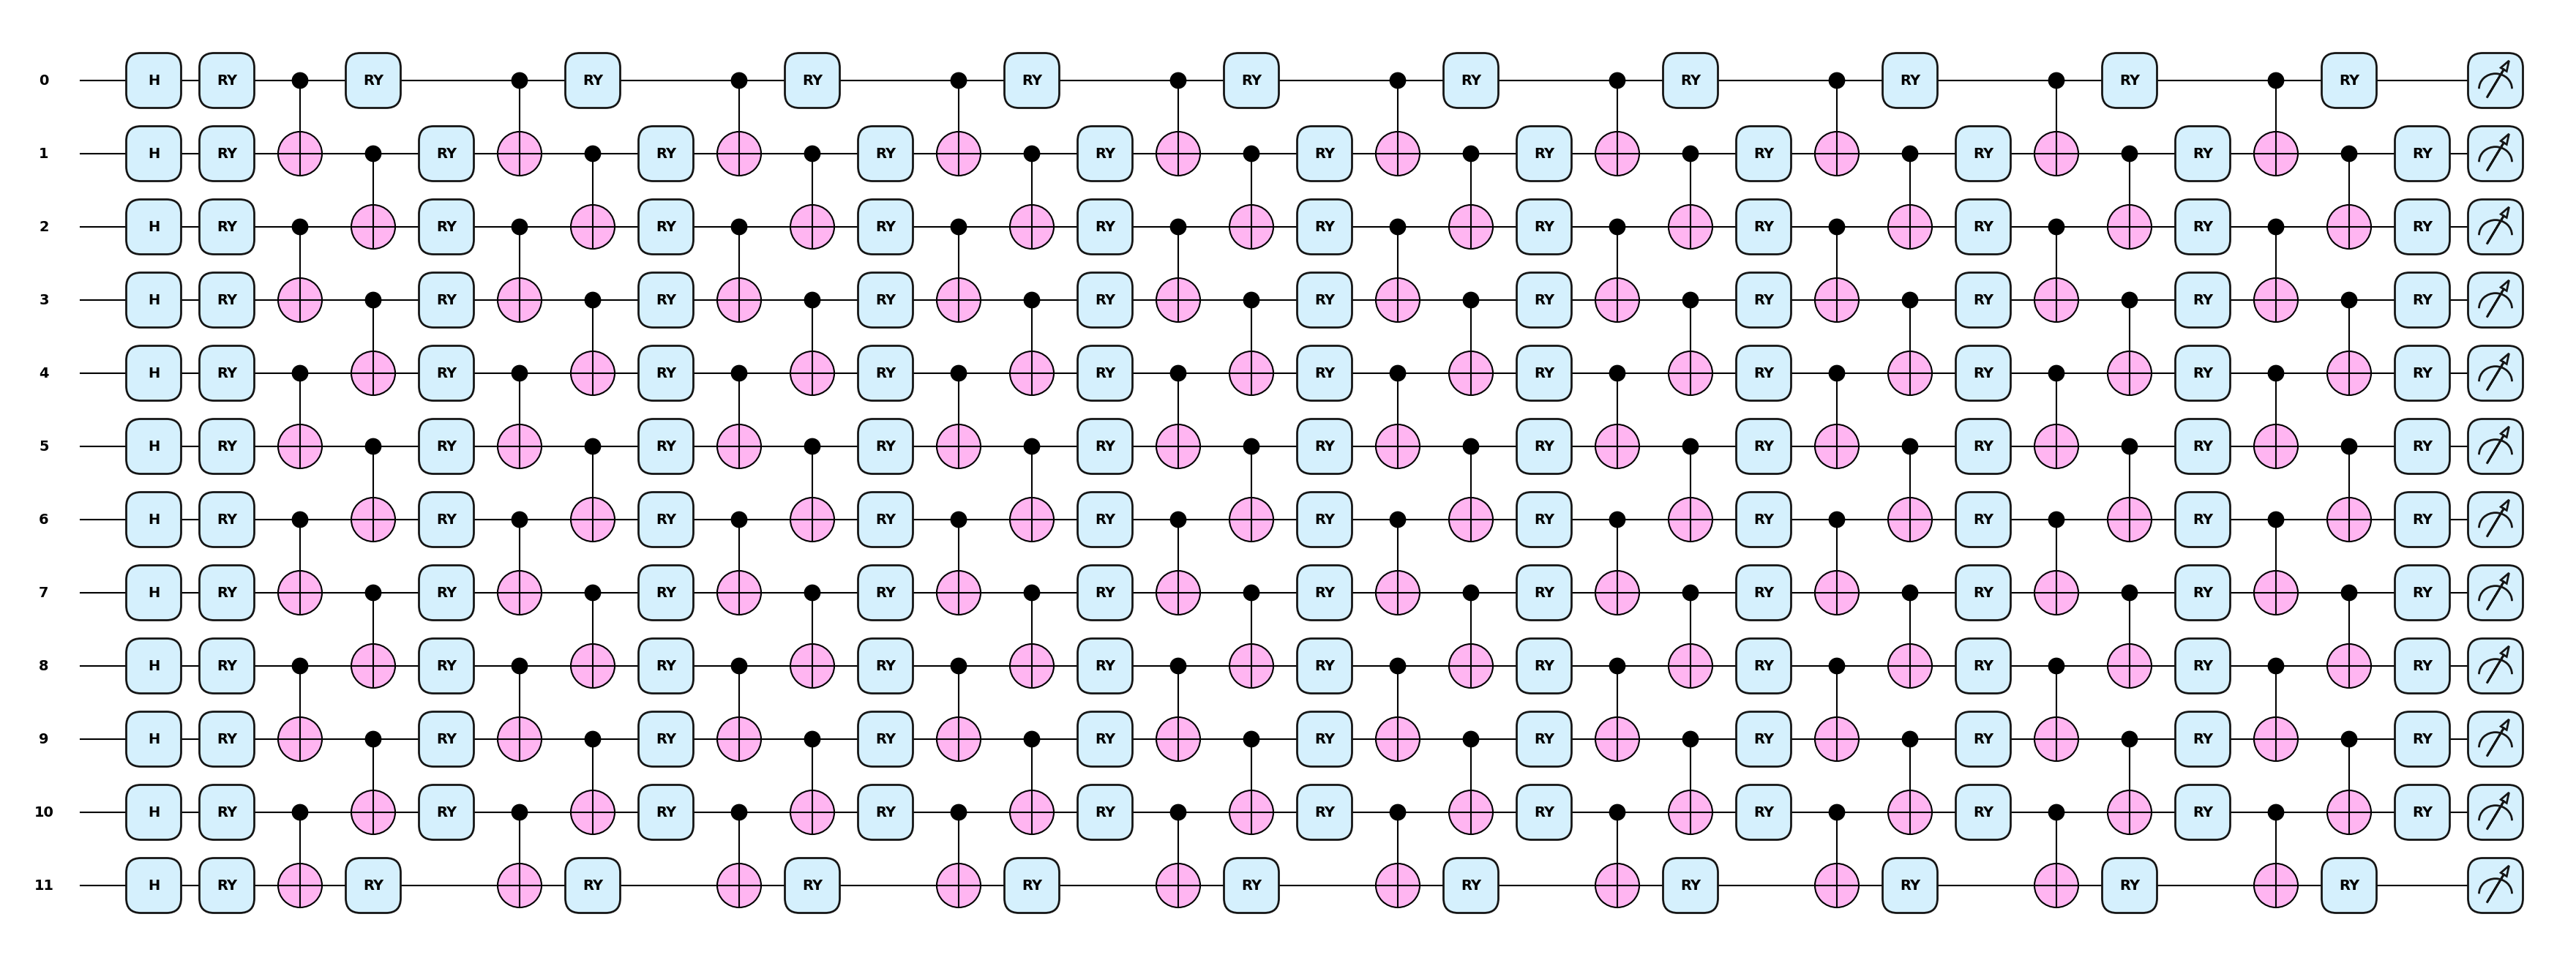

In [9]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

In [10]:
def U3_layer(nqubits):
    """layer of single qubit u3 rotations.
    """
    params = np.random.uniform(0, 2*np.pi, (nqubits, 3))
    for idx in range(nqubits):
        qml.U3(params[idx][0], params[idx][1], params[idx][2], wires=idx)

def RZ_layer(w):
    """layer of parametrized qubit rotations around the z axis.
    """
    for idx, element in enumerate(w):
        qml.RZ(element, wires=idx)

def entangline_layer_2(nqubits):
    for i in range(0, nqubits - 2, 1):
        qml.Toffoli(wires=[i, i + 1, i + 2])

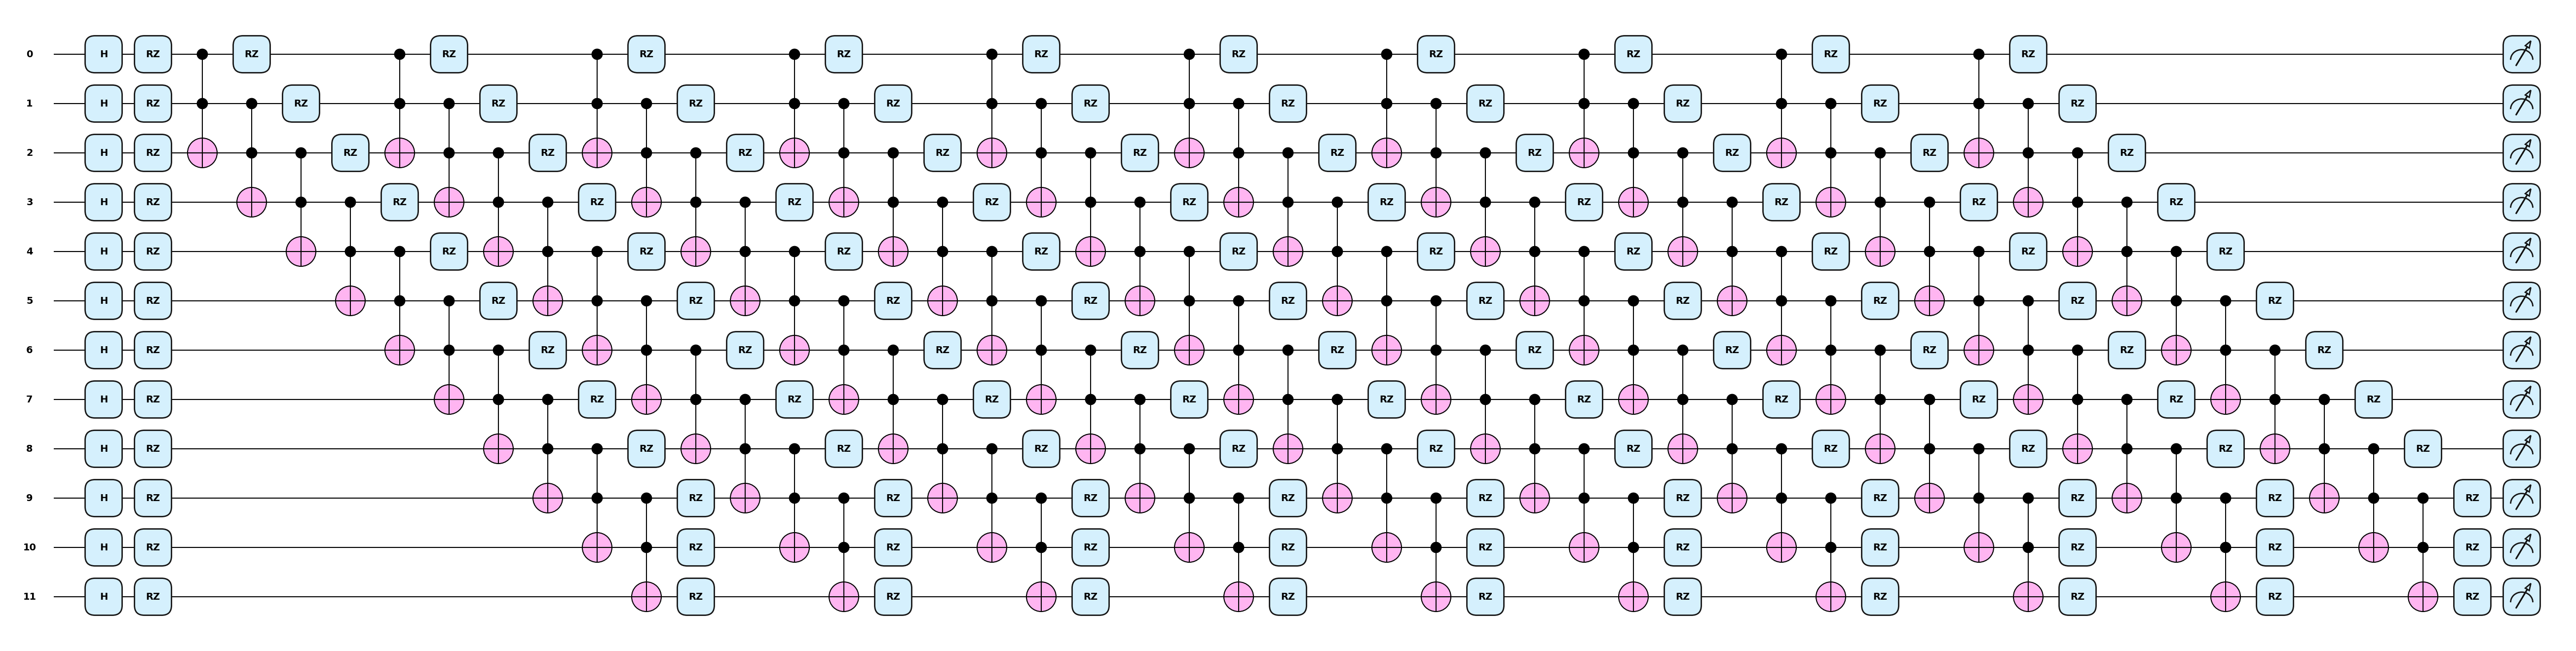

In [11]:
@qml.qnode(dev)
def quantum_net_2(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # use the U3 layer as reference representation layer
    H_layer(n_qubits)

    # Embed features in the quantum node
    RZ_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangline_layer_2(n_qubits)
        RZ_layer(q_weights[k])

    # Expectation values in the y basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net_2)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

In [28]:
def phase_layer(w):
    """Layer of S gates and T gates to flip the phase of the qubits.
    """
    for idx in range(w):
        if idx % 2 == 0:
            qml.S(wires=idx)
        else:
            qml.T(wires=idx)

def entangling_layer_3(nqubits):
    """Layer of controlled-Rz gates followed by zz entangling gates. 
    """
    params = np.random.uniform(0, 2*np.pi, (nqubits,))
    for i in range(0, nqubits - 1, 2):
        qml.ctrl(qml.RZ, control=i)(params[i], wires=i + 1)
    for i in range(1, nqubits - 1, 2):
        qml.IsingZZ(params[i],wires=[i, i + 1])

def entangling_layer_4(nqubits):
    """
    Constructs an n-qubit W state using CRY and CNOT gates.
    
    Args:
        nqubits (int): Number of qubits.
    """
    # Step 1: Apply Hadamard to the first qubit
    qml.Hadamard(wires=0)

    # Step 2: Apply controlled rotations (CRY) to distribute amplitudes
    for i in range(nqubits - 1):
        theta = 2 * np.arcsin(np.sqrt(1 / (nqubits - i)))  # Compute rotation angle
        qml.CRY(theta, wires=[i, i + 1])  # Apply CRY from qubit i to qubit i+1

    # Step 3: Apply CNOT gates for entanglement
    for i in range(nqubits - 1):
        qml.CNOT(wires=[i, i + 1])

def measurement_layer(nqubits):
    """Measurement layer in the Z basis.
    """
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]


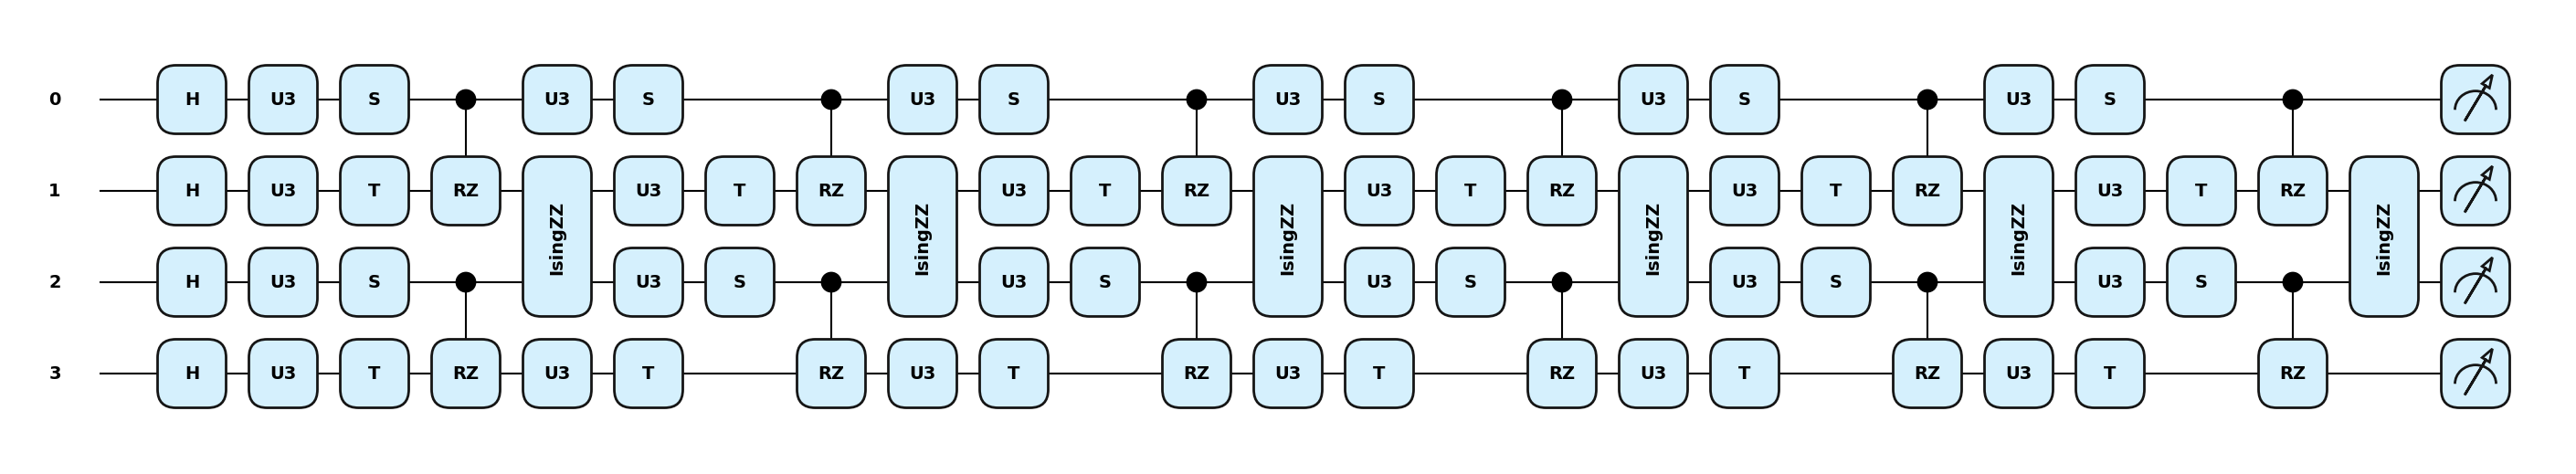

In [29]:
@qml.qnode(dev)
def quantum_net_3(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)


    # Sequence of trainable variational layers
    for _ in range(q_depth):
        U3_layer(n_qubits)
        phase_layer(n_qubits)
        entangling_layer_3(n_qubits)
        
    exp_val = measurement_layer(n_qubits)
    # Measurement layer
    return tuple(exp_val)

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net_3)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

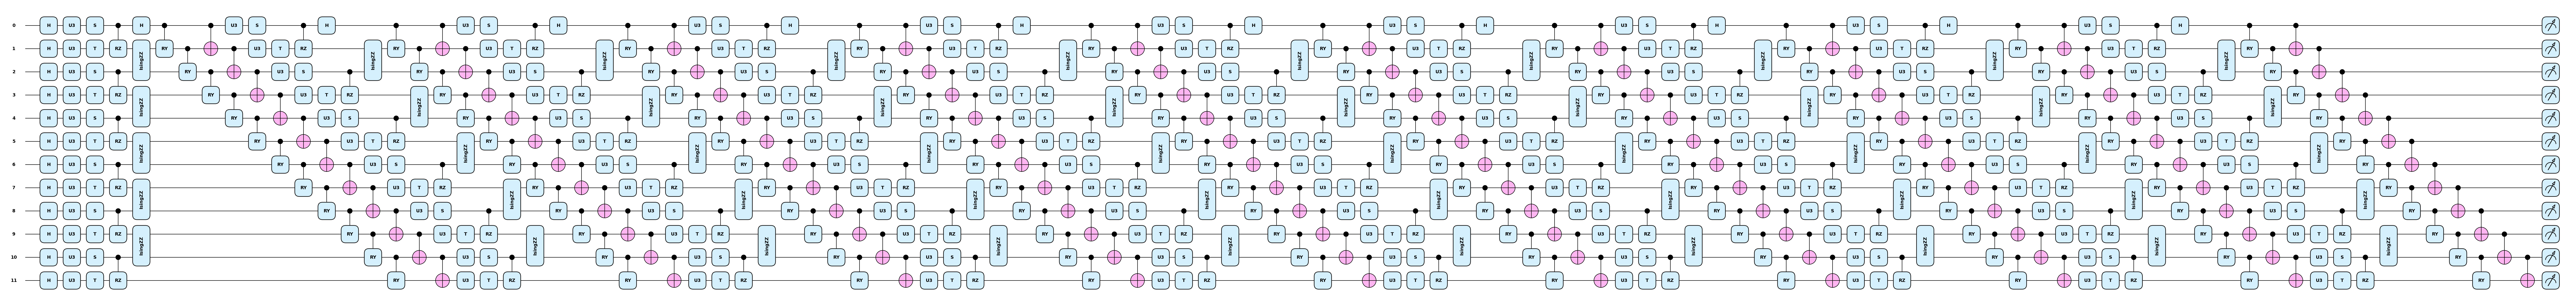

In [14]:
@qml.qnode(dev)
def quantum_net_4(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)


    # Sequence of trainable variational layers
    for _ in range(q_depth):
        U3_layer(n_qubits)
        phase_layer(n_qubits)
        entangling_layer_3(n_qubits)
        entangling_layer_4(n_qubits)
        
    exp_val = measurement_layer(n_qubits)
    # Measurement layer
    return tuple(exp_val)

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net_4)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

In [30]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features.to(device))
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net_3(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem.to(device)))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [31]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()
# model_hybrid.fc = nn.Linear(512, 200)

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [32]:
from torch.utils.data import DataLoader
# 为数据创建 DataLoader
train_loader = DataLoader(train_subsets[0], batch_size=batch_size, shuffle=True)

# 获取一个 batch 的数据
inputs, labels = next(iter(train_loader))

# 确保输入数据的形状是 [batch_size, channels, height, width]
print(f"Input shape: {inputs.shape}")  # 应该是 [batch_size, 3, 64, 64]

# 将输入传递给模型
outputs = model_hybrid(inputs.to(device))
print(f"Model output shape: {outputs.shape}")  # 应该是 [batch_size, 200]

Input shape: torch.Size([64, 3, 64, 64])
Model output shape: torch.Size([64, 200])


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
# exp_lr_scheduler = lr_scheduler.StepLR(
#     optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
# )
loggers = []

# log to Tensorboard
loggers.append(TensorboardLogger())

# log to text file
loggers.append(TextLogger(open('quantum_lwf_net3_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())



In [34]:
# 7. Define evaluation plugin for logging metrics
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=num_classes, save_image=True,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=loggers
)

In [35]:
strategy = LwF(
    model=model_hybrid,
    optimizer=optimizer_hybrid,
    criterion=criterion,
    alpha=alpha,  # 平衡新任务和旧任务损失的权重
    temperature=temperature,  # 蒸馏温度，越高的值越软化
    train_mb_size=train_mb_size,
    train_epochs=num_epochs,
    eval_mb_size=eval_mb_size,
    evaluator=eval_plugin,
    device=device
)

In [36]:
# 9. Training and evaluation loop
# Use experiences from Avalanche's benchmark, such as from benchmark.train_stream

results = []    
# Iterate over experiences from the benchmark's training stream
for experience in benchmark.train_stream:
    # Train on the current experience
    print(f"Start Training on of experience: {experience.current_experience}")
    strategy.train(experience)
    print(f"Evaluation on the current experience: {experience.current_experience}")
    # Evaluate the current model on the current test experience
    results.append(strategy.eval(benchmark.test_stream))
# 将结果保存到文件
if not os.path.exists('quantum_lwf_net1_results.txt'):
    with open('quantum_lwf_net1_results.txt', 'w') as f:
        f.write('Results of quantum_lwf_net3\n')
with open('quantum_lwf_net1_results.txt', 'a') as f:
    for res in results:
        f.write(str(res) + '\n')

Start Training on of experience: 0
-- >> Start of training phase << --
100%|██████████| 40/40 [07:13<00:00, 10.83s/it]
Epoch 0 ended.
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 48675.9502
	DiskUsage_MB/train_phase/train_stream/Task000 = 48675.9502
	Loss_Epoch/train_phase/train_stream/Task000 = 5.3596
	Loss_MB/train_phase/train_stream/Task000 = 5.3368
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.2680
	Time_Epoch/train_phase/train_stream/Task000 = 433.0997
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0061
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 40/40 [07:06<00:00, 10.65s/it]
Epoch 1 ended.
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 50216.1367
	DiskUsage_MB/train_phase/train_stream/Task000 = 50216.1367
	Loss_Epoch/train_phase/train_stream/Task000 = 5.3590
	Loss_MB/train_phase/train_stream/Task000 = 5.1711
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.2761
	Time_Epoch/train_phase/train_stream/Task000 = 426.1406


KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard